In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Softmax, MaxPooling2D
from coord_conv import CoordConv
import utils
import utils_vis
import utils_model

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

In [2]:
def model_regression(inps): 
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 20, 
              kernel_size = 1)(inps)
    conv01 = Conv2D(20,1, activation = None)(coord01) 
    conv02 = Conv2D(20,1, activation = None)(conv01)
    conv03 = Conv2D(20,1, activation = None)(conv02)
    conv04 = Conv2D(20,1, activation = None)(conv03) 
    conv05 = Conv2D(20,1, activation = None)(conv04) 
    conv06 = Conv2D(20,3, activation = None)(conv05) 
    conv07 = Conv2D(2,3 ,activation = None)(conv06) 
    output = MaxPooling2D( pool_size= 96, strides = 96, padding='valid')(conv07)
    return output 

def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)
    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size, img_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
    squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score


In [3]:
n_neurons = 2
IMG_SIZE = 100
BATCH_SIZE = 8
lr=0.1

neuron_imgs_list = []
coords,_, ori_one_hot_imgs = utils_model.create_dat_samples(n_neurons, IMG_SIZE)
coords = tf.reshape(coords, [n_neurons, 1,1,2]) #for the input shape of deconv 

for i in range(BATCH_SIZE):
    neuron_imgs = tf.squeeze(utils_model.neuron_like_image(n_neurons, IMG_SIZE))
    neuron_imgs_list.append(neuron_imgs)
neuron_imgs_list = tf.expand_dims(tf.convert_to_tensor(neuron_imgs_list), -1)


In [4]:
#build coord-deconv model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#build reg model
model_input = Input(shape=(100,100,1))
coordconv = Model(model_input, model_regression(model_input))
coordconv.load_weights("best_reg_model100_02.hdf5")

In [5]:
#loss function 
mse = tf.losses.MeanSquaredError()
def test_fn(inp_imgs, coords, img_size):
    norm_coords = coords/(img_size-1)
    m1 = tf.constant([1,img_size, img_size,1], tf.int32) #multiplier for tiling 
    tile_cd = tf.tile(norm_coords, m1)
    #deconv
    de_coordconv.trainable = False #freeze de-coordconv
    one_hot_imgs = tf.reshape(de_coordconv(tile_cd), [-1, img_size, img_size, 1])
    #dot product
    similarity_score = tf.tensordot(inp_imgs, one_hot_imgs, [[1,2,3],[1,2,3]])
    #multiply similarity scores with one hot images
    similarity_multi = tf.einsum('ij,jklm->ijklm', similarity_score, one_hot_imgs) #(batch_size, n_neurons, img_size, img_size,1)
    #sum the one hot images for all neurons to compute MSE
    similarity_multi_reduced_neurons = tf.reduce_sum(similarity_multi, axis=1)#(batch_size, img_size, img_size, 1)
    similarity_multi_max_batch = tf.reduce_max(similarity_multi, axis = 0)#(n_neurons,img_size,mg_size,1)
    #generate coordinates from coordconv model 
    coordconv.trainable = True 
    generate_coords = coordconv(similarity_multi_max_batch)
    #reconstruciton loss 
    loss = mse(inp_imgs, similarity_multi_reduced_neurons)
    
    return loss, one_hot_imgs, generate_coords, similarity_multi_reduced_neurons, similarity_multi_max_batch 

In [6]:
loss, one_hot_imgs, generate_coords, similarity_multi_reduced_neurons, similarity_multi_max_batch  = test_fn(neuron_imgs_list, coords, IMG_SIZE)

In [7]:
print(loss.numpy())

0.0002


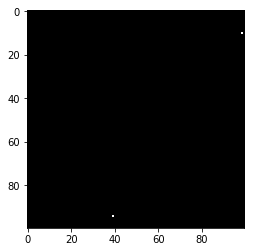

In [8]:
plt.imshow(tf.squeeze(neuron_imgs_list[0]), cmap = 'gray')

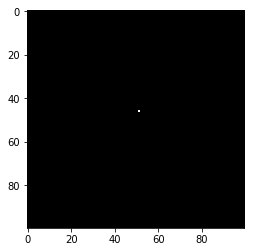

In [9]:
plt.imshow(tf.squeeze(np.sum(similarity_multi_max_batch, axis=0)), cmap = 'gray')

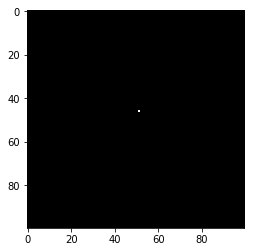

In [10]:
plt.imshow(tf.squeeze(similarity_multi_reduced_neurons[1]), cmap = 'gray')

In [13]:
generate_coords

<tf.Tensor: shape=(2, 1, 1, 2), dtype=float32, numpy=
array([[[[3.9520926, 4.0238233]]],


       [[[3.9520926, 4.0238233]]]], dtype=float32)>

In [14]:
coords

<tf.Tensor: shape=(2, 1, 1, 2), dtype=float32, numpy=
array([[[[38., 54.]]],


       [[[51., 46.]]]], dtype=float32)>

In [11]:
#optimizer 
opt= tf.keras.optimizers.Adam(lr)
#loss function 
mse = tf.losses.MeanSquaredError()
@tf.function
def train_fn(inp_imgs, coords, img_size):
    with tf.GradientTape(persistent=True) as tape:
        #normalizing the coordinates 
        norm_coords = coords/(img_size-1)
        m1 = tf.constant([1,img_size, img_size,1], tf.int32) #multiplier for tiling 
        tile_cd = tf.tile(norm_coords, m1)
        #deconv
        de_coordconv.trainable = False #freeze de-coordconv
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd), [-1, img_size, img_size, 1])
        #dot product
        similarity_score = tf.tensordot(inp_imgs, one_hot_imgs, [[1,2,3],[1,2,3]])
        #multiply similarity scores with one hot images
        similarity_multi = tf.einsum('ij,jklm->ijklm', similarity_score, one_hot_imgs) #(batch_size, n_neurons, img_size, img_size,1)
        #sum the one hot images for all neurons to compute MSE
        similarity_multi_reduced_neurons = tf.math.reduce_sum(similarity_multi, axis=1)#(batch_size, img_size, img_size, 1)
        similarity_multi_max_batch = tf.math.reduce_max(similarity_multi, axis = 0)#(n_neurons,img_size,mg_size,1)
        #reconstruciton loss 
        loss = mse(inp_imgs, similarity_multi_reduced_neurons)
        #generate coordinates from coordconv model 
        coordconv.trainable = True 
        generate_coords = coordconv(similarity_multi_max_batch)

    #back prop through coordconv
    grad = tape.gradient(loss, coordconv.trainable_variables)
    opt.apply_gradients(zip(grad, coordconv.trainable_variables))
    
    return loss, generate_coords, one_hot_imgs, similarity_score, grad

In [12]:
steps = 0
while steps<=1000:
    if steps==0:
        updated_coords = coords
    loss, generate_coords, one_hot_imgs, similarity_score, grad = train_fn(neuron_imgs_list, updated_coords, IMG_SIZE)
    updated_coords = generate_coords
    
    print("Loss: {}".format(loss))

ValueError: in converted code:

    <ipython-input-11-74f285d8b045>:30 train_fn  *
        opt.apply_gradients(zip(grad, coordconv.trainable_variables))
    /home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:426 apply_gradients
        grads_and_vars = _filter_grads(grads_and_vars)
    /home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:1039 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['coord_conv_1/conv2d_6/kernel:0', 'coord_conv_1/conv2d_6/bias:0', 'conv2d_7/kernel:0', 'conv2d_7/bias:0', 'conv2d_8/kernel:0', 'conv2d_8/bias:0', 'conv2d_9/kernel:0', 'conv2d_9/bias:0', 'conv2d_10/kernel:0', 'conv2d_10/bias:0', 'conv2d_11/kernel:0', 'conv2d_11/bias:0', 'conv2d_12/kernel:0', 'conv2d_12/bias:0', 'conv2d_13/kernel:0', 'conv2d_13/bias:0'].
